# Optimizing Zmap for "on-the-fly" text classification
This notebook is the first of two to accompany our [Few-Shot Text Classification](https://few-shot-text-classification.fastforwardlabs.com/) report in which we dive into the ins and outs of latent text embeddings for text classifications in several limited-labeled-data regimes. One such regime is what we call "on-the-fly" text classification in which no labeled data exists. To classify text with no labeled training data we rely on the inherent meaning of the labels themselves and embed both the label name and the text document with Sentence-BERT. Classification proceeds by assiging the label name whose embedding maximizes the cosine similarity to the text document embedding. 

 To enhance the classification accuracy of this method, this notebook focuses on how to optimize a mapping (Zmap) between Sentence-BERT (SBERT) embedding space and word2vec (w2v) embedding space since SBERT is optimized to generate representations for *sentences*, while w2v is optimized for *words*. 

  In the following experiments we use two datasets: AG News and the Reddit dataset, both of which can be found on the [HuggingFace Dataset Repository](link) (CAUTION: the Reddit dataset is *very* large and takes a looooong time to download. In our experiments we have already downsampled the dataset to fit in memory. Details on how we did that can be found in [this](link) notebook.)

### Notes
* Because this notebook utilizes a Transformer model, GPUs are the prefered hardware if embedding more than a handful of text documents. 
* This notebook requires the use of the original word2vec embeddings (which take a while to download for the first time)

### Data to upload
* Word2Vec model
* reddit dataset


In [ ]:
 # clone our few-shot repo 
 !git clone https://github.com/fastforwardlabs/few-shot-text-classification.git

Cloning into 'few-shot-text-classification'...
remote: Enumerating objects: 442, done.
remote: Counting objects: 100% (442/442), done.
remote: Compressing objects: 100% (275/275), done.
remote: Total 442 (delta 281), reused 294 (delta 148), pack-reused 0
Receiving objects: 100% (442/442), 222.90 KiB | 1.01 MiB/s, done.
Resolving deltas: 100% (281/281), done.


In [ ]:
!pip3 install datasets
!pip3 install transformers
!pip3 install -e .

In [ ]:
import os
import pickle
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm, tnrange
from torch.utils.data import TensorDataset, DataLoader

from fewshot.embeddings import word_embeddings as w2v
from fewshot.embeddings import transformer_embeddings as transf
from fewshot.predictions import compute_predictions, compute_predictions_projection
from fewshot.metrics import simple_accuracy, simple_topk_accuracy
from fewshot.data.loaders import (
    load_or_cache_data, 
    Dataset,
    _prepare_category_names
)
from fewshot.utils import (
    fewshot_filename, 
    torch_load,
    pickle_load, 
    pickle_save,
    torch_load,
    to_tensor, 
    to_list, 
    torch_save,  
    compute_projection_matrix
)

In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

# Load a dataset (or three)

In [ ]:
# ag news dataset contains `distilbert/sentence_bert` embeddings
news_data = load_or_cache_data("data", "agnews")
news_categories = len(news_data.categories)

Checking for cached data...


In [ ]:
#reddit_data = load_or_cache_data("data", "reddit")
reddit_data = torch.load("data/reddit_dataset.pt")
reddit_categories = len(reddit_data.categories)

# Load SentenceBERT and W2V embedding models

In [ ]:
## Load SBERT embedding model
model, tokenizer = transf.load_transformer_model_and_tokenizer("deepset/sentence_bert")

In [ ]:
## Load W2V embedding model
w2v_model = w2v.load_word_vector_model(small=True) #, cache_dir="data"

# Experiment: How many words should we use to create Z map? 

For this experiment we'll use the W2V vocabulary, which includes millions of words. As we'll see, we won't need nearly this many to maximize the contribution of Z map to our latext text classification task. 

### Get SBERT and W2V embedding vectors for the topk words in the W2V vocabulary

We'll use the most frequent words as computed over the corpus that was used to train the w2v embeddings. This was a very large corpus so the most frequent words should be those that are used ... well, frequently!  The assumption is that using the most frequently used words to create a mapping between SBERT space and W2V space will provide optimal performance for classification. 

In [ ]:
# Get w2v embeddings and the vocabulary of most frequent words
w2v_vectors, vocabulary = w2v.get_topk_w2v_vectors(w2v_model, k=100000, return_word_list=True)
vocabulary_filename = "data/w2v_vocab_sbert_embeddings.pt"

try:
  sbert_vectors = torch_load(vocabulary_filename)['embeddings']
except:
  # get sbert embeddings for each word in vocabulary
  sbert_vectors = transf.get_transformer_embeddings(vocabulary, 
                                                    model, 
                                                    tokenizer, 
                                                    output_filename=vocabulary_filename)

We'll compute Z map with *up to* 100,000 words, starting small with just 100 words and increasing in steps of 100 to 1000 until we cover the range up to 100,000. 

Below is the number of words we'll use to compute Z map at each iteration.











In [2]:
import numpy as np
num_words = np.concatenate((np.arange(10**2, 10**3, 100), np.arange(10**3, 10**5+990, 1000)))
num_words

array([   100,    200,    300,    400,    500,    600,    700,    800,
          900,   1000,   2000,   3000,   4000,   5000,   6000,   7000,
         8000,   9000,  10000,  11000,  12000,  13000,  14000,  15000,
        16000,  17000,  18000,  19000,  20000,  21000,  22000,  23000,
        24000,  25000,  26000,  27000,  28000,  29000,  30000,  31000,
        32000,  33000,  34000,  35000,  36000,  37000,  38000,  39000,
        40000,  41000,  42000,  43000,  44000,  45000,  46000,  47000,
        48000,  49000,  50000,  51000,  52000,  53000,  54000,  55000,
        56000,  57000,  58000,  59000,  60000,  61000,  62000,  63000,
        64000,  65000,  66000,  67000,  68000,  69000,  70000,  71000,
        72000,  73000,  74000,  75000,  76000,  77000,  78000,  79000,
        80000,  81000,  82000,  83000,  84000,  85000,  86000,  87000,
        88000,  89000,  90000,  91000,  92000,  93000,  94000,  95000,
        96000,  97000,  98000,  99000, 100000])

We'll iterate over the `num_words`, selecting the same words from both the sbert_embeddings and w2v_embeddings. These embeddings will be used to compute Z map. The Z map matrix is then used to compute label predictions for a dataset. The resulting score is stored to an array so we can see how the score changes as a function of the number of words. 

In [3]:
def predict_and_score(dataset, num_categories, Zmap=None, return_predictions=False):
  if Zmap is None:
    # compute predictions using only sbert embeddings
    predictions = compute_predictions(dataset.embeddings[:-num_categories], 
                                      dataset.embeddings[-num_categories:])
  else:
    # compute predictions using a sbert embedding \times Zmap projection 
    predictions = compute_predictions_projection(dataset.embeddings[:-num_categories], 
                                                 dataset.embeddings[-num_categories:],
                                                 Zmap)
  # compute the score for the predictions
  score = simple_accuracy(dataset.labels, predictions)
  if return_predictions:
    return score, predictions
  return score 

def how_many_words(dataset, num_words):
  num_categories = len(dataset.categories)
  scores = []
  for i in num_words:
      # compute Zmap between the sbert embeddings and w2v embeddings for the 
      # first i words
      Zmap = compute_projection_matrix(sbert_vectors[:i], to_tensor(w2v_vectors[:i]))
      score = predict_and_score(dataset, num_categories, Zmap)
      # save the score 
      scores.append(score)
  return scores

In [ ]:
news_scores = how_many_words(news_data, num_words[:10])

In [ ]:
reddit_scores = how_many_words(reddit_data, num_words)

In [ ]:
pickle.dump(news_scores, open("howmanywords_agnews_scores.pkl", "wb"))

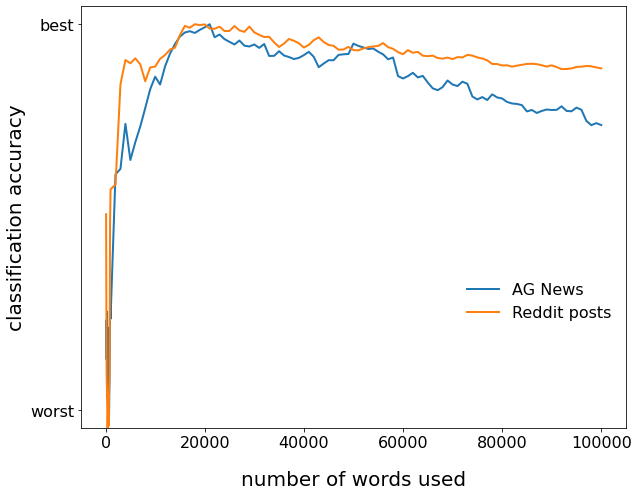

In [6]:
# I've already run this for three datasets and saved the resulting scores
news_scores = pickle.load(open("howmanywords_agnews_scores.pkl", "rb"))
#amazon_scores = pickle.load(open("howmanywords_amazon_scores.pkl", "rb"))
reddit_scores = pickle.load(open("howmanywords_redditcurated_scores.pkl", "rb"))

fig = plt.figure(figsize=(9,7))
ax = fig.add_subplot()

ax.plot(num_words, np.array(news_scores)/max(news_scores), lw=2, label='AG News');
#ax.plot(num_words, np.array(amazon_scores)/max(amazon_scores), lw=2, label='Amazon product descriptions');
ax.plot(num_words, np.array(reddit_scores)/max(reddit_scores), lw=2, label='Reddit posts');

ax.set_yticks([0.35, 1])
ax.set_yticklabels(["worst", "best"])
ax.tick_params(axis='both', labelsize=16)
ax.set_xlabel("number of words used", labelpad=20, fontsize=20)
ax.set_ylabel("classification accuracy", fontsize=20)
ax.set_ylim(.32, 1.03)

plt.legend(loc="right", bbox_to_anchor=(1., 0.3),  frameon=False, fontsize=16);
plt.tight_layout()
plt.savefig("Zmaps_howmanywords.png", dpi=150)

# Experiment: words from the W2V corpus vs words from your specific corpus?

In the previous experiment we used the most frequent words as measured over the vast corpus that the w2v model was trained on, but that's not the only option. Perhaps it's better to use the most frequent words as measured over the examples you're trying to classify! 

For this we'll need to set a baseline--in this case, classification performance without using any kind of Zmap. 

### Baseline: SBERT embeddings only

In [ ]:
baseline_news_acc, news_preds = predict_and_score(news_data, 
                                         news_categories, 
                                         Zmap=None, 
                                         return_predictions=True)
baseline_news_acc_top3 = simple_topk_accuracy(news_data.labels, news_preds)

print(baseline_news_acc, baseline_news_acc_top3)

51.0921052631579 89.67105263157895


In [ ]:
baseline_reddit_acc, reddit_preds = predict_and_score(reddit_data, 
                                             reddit_categories, 
                                             Zmap=None, 
                                             return_predictions=True)
baseline_reddit_acc_top3 = simple_topk_accuracy(reddit_data.labels, reddit_preds)

print(baseline_reddit_acc, baseline_reddit_acc_top3)

37.46923076923077 61.01538461538462


### Zmap: Construct from most frequent words in w2v training corpus

We'll construct a Zmap using the w2v vocabulary consisting of the most frequently used 20,000 words, since we found in the previous section that this many words typically provides the best performing Zmap.

In [ ]:
try:
  Zmap_w2v = torch.load("data/Zmaps/Zmap_20k_w2v_words_alpha0.pt")
except:
  w2v_vectors, vocabulary = w2v.get_topk_w2v_vectors(w2v_model, k=20000, return_word_list=True)
  vocabulary_filename = "data/w2v_vocab20k_sbert_embeddings.pt"

  try:
    sbert_vectors = torch_load(vocabulary_filename)['embeddings']
  except:
    # get sbert embeddings for each word in vocabulary
    sbert_vectors = transf.get_transformer_embeddings(vocabulary, 
                                                      model, 
                                                      tokenizer, 
                                                      output_filename=vocabulary_filename)

  Zmap_w2v = compute_projection_matrix(sbert_vectors, to_tensor(w2v_vectors))

  #torch.save(Zmap_w2v, "data/Zmap_20k_w2v_words_alpha0.pt")

In [ ]:
zw2v_news_acc, news_preds = predict_and_score(news_data, 
                                         news_categories, 
                                         Zmap=Zmap_w2v, 
                                         return_predictions=True)
zw2v_news_acc_top3 = simple_topk_accuracy(news_data.labels, news_preds)

print(zw2v_news_acc, zw2v_news_acc_top3)

65.57894736842104 95.98684210526316


In [ ]:
zw2v_reddit_acc, reddit_preds = predict_and_score(reddit_data, 
                                             reddit_categories, 
                                             Zmap=Zmap_w2v, 
                                             return_predictions=True)
zw2v_reddit_acc_top3 = simple_topk_accuracy(reddit_data.labels, reddit_preds)

print(zw2v_reddit_acc, zw2v_reddit_acc_top3)

33.53076923076923 60.099999999999994


Using a Zmap constructed from the most frequent 20k words as measured over the corpus that w2v embeddings were trained on definitely improved performance for the AG news dataset (increasing accuracy by nearly 15 points!), but it made our classification worse for the reddit dataset.

word2vec embeddings were trained on 100 billion words of the Google News dataset and the most frequent words are based on the distribution contained with the Google News dataset. It is perhaps not surprising, then, that choosing the most frequent words from a news corpus improves performance on another news corpus. 

Perhaps using the most frequently used words on Reddit will yield a better choice of Zmap for the reddit dataset. 

#### Side Quest: fine-tuning the regularization
Turns out you can increase the performance by about another 5 points depending on the regularization parameter. The drawback, however, is that fine-tuning parameters requires *some*  labeled data in order to properly evaluate between different values. In our experiments we find that values beteen 5 and 12 tend to work best for most datasets. 

In [ ]:
for alpha in [0.1, 1, 5, 10, 15, 20]:
  Zmap = compute_projection_matrix(sbert_vectors, 
                                   to_tensor(w2v_vectors), 
                                   alpha=alpha)

  news_acc = predict_and_score(news_data, 
                                news_categories, 
                                Zmap=Zmap, 
                                return_predictions=False)
  
  reddit_acc = predict_and_score(reddit_data, 
                                  reddit_categories, 
                                  Zmap=Zmap, 
                                  return_predictions=False)
  print(f"alpha: {alpha} \t news_acc: {news_acc} \t reddit_acc: {reddit_acc}")

alpha: 0.1 	 news_acc: 66.07894736842105 	 reddit_acc: 32.751462254144315
alpha: 1 	 news_acc: 68.38157894736842 	 reddit_acc: 34.357668878989
alpha: 5 	 news_acc: 71.05263157894737 	 reddit_acc: 34.927417644028246
alpha: 10 	 news_acc: 71.39473684210526 	 reddit_acc: 34.60617631905931
alpha: 15 	 news_acc: 71.01315789473685 	 reddit_acc: 34.342515986301784
alpha: 20 	 news_acc: 70.47368421052632 	 reddit_acc: 34.172803588204985


In [ ]:
try:
  Zmap_w2v_opt4news = torch.load("data/Zmaps/Zmap_20k_w2v_words_alpha10_news.pt")
except:
  Zmap_w2v_opt4news = compute_projection_matrix(sbert_vectors, 
                                                to_tensor(w2v_vectors), 
                                                alpha=10)
  torch.save(Zmap_w2v_opt4news, "data/Zmap_20k_w2v_words_alpha10_news.pt")

try:
  Zmap_w2v_opt4reddit = torch.load("data/Zmaps/Zmap_20k_w2v_words_alpha5_reddit.pt")
except:
  Zmap_w2v_opt4reddit = compute_projection_matrix(sbert_vectors, 
                                                  to_tensor(w2v_vectors), 
                                                  alpha=5)
  torch.save(Zmap_w2v_opt4reddit, "data/Zmap_20k_w2v_words_alpha5_reddit.pt")

### Zmap: Construct from most frequent words in a specific corpus (e.g., Reddit)

Next, we'll construct a Zmap using the most frequent words as measured over the Reddit dataset.  computing most frequent reddit words in the jupyter notebook where I filtered the dataset

In [ ]:
most_common_reddit_words = pickle.load(open("data/most_common_words.pkl","rb"))

In [ ]:
# not all words have embeddings in the canonical version of w2v
# identify top 20k words in the reddit word list that also have w2v embeddings

w2v_vectors_redditwords, words_not_found = w2v.get_word_embeddings(
    most_common_reddit_words['no_punc_no_stop'], 
    w2v_model)

#select the top20k w2v embeddings (corresponding to the top 20k words in common)
w2v_vectors_redditwords = w2v_vectors_redditwords[:20000]

# identify the words in common
words_not_found = set(words_not_found)
common_words = []
for word in most_common_reddit_words['no_punc_no_stop']:
  if word not in words_not_found:
    common_words.append(word)

top20k_common_words = common_words[:20000]

In [ ]:
vocabulary_filename = "data/reddit_vocab20k_sbert_embeddings.pt"

try:
  sbert_vectors_redditwords = torch_load(vocabulary_filename)['embeddings']
except: 
  # compute sbert vectors for the top20_common_words
  sbert_vectors_redditwords = transf.get_transformer_embeddings(top20k_common_words, 
                                                    model, 
                                                    tokenizer, 
                                                    output_filename=vocabulary_filename)

In [ ]:
Zmap_redditwords = compute_projection_matrix(sbert_vectors_redditwords, 
                                             to_tensor(w2v_vectors_redditwords))

zred_reddit_acc, reddit_preds = predict_and_score(reddit_data, 
                                              reddit_categories, 
                                              Zmap=Zmap_redditwords, 
                                              return_predictions=True)
zred_reddit_acc_top3 = simple_topk_accuracy(reddit_data.labels, reddit_preds)

print(zred_reddit_acc, zred_reddit_acc_top3)

25.108343182713583 59.55692941782586


In [ ]:
try:
  Zmap_redditwords = torch.load("data/Zmaps/Zmap_20k_reddit_words_alpha0.pt")
except:
  Zmap_redditwords = compute_projection_matrix(sbert_vectors_redditwords, 
                                              to_tensor(w2v_vectors_redditwords))

  torch.save(Zmap_redditwords, "data/Zmap_20k_reddit_words_alpha0.pt")

Unfortunately, constructing Zmap from a vocabulary of the most frequent words in the Reddit dataset doesn't help; in fact, it hurts performance even more! 

On the bright side, even a small amount of regularization will improve the performance significantly (even if it doesn't outperform using SBERT embeddings alone).  Below, we see that even having `alpha=1` increases the score by 6 points. 

In [ ]:
def fine_tune_alpha(alpha_values, dataset, sbert_vectors, w2v_vectors, verbose=True):
  num_categories = len(dataset.categories)

  for alpha in alpha_values:
    Zmap = compute_projection_matrix(sbert_vectors, 
                                    to_tensor(w2v_vectors), 
                                    alpha=alpha)
    
    acc = predict_and_score(dataset, 
                            num_categories, 
                            Zmap=Zmap, 
                            return_predictions=False)
    if verbose:
      print(f"alpha: {alpha} \t score: {acc}")

In [ ]:
alpha = [0, 0.1, 1, 5, 10, 15]
fine_tune_alpha(alpha, reddit_data, sbert_vectors_redditwords, w2v_vectors_redditwords)

alpha: 0 	 score: 25.108343182713583
alpha: 0.1 	 score: 28.896566354517077
alpha: 1 	 score: 31.36042670545807
alpha: 5 	 score: 32.799951510743405
alpha: 10 	 score: 33.06664242203837
alpha: 15 	 score: 33.01815316543929


In [ ]:
try:
  Zmap_reddit_opt = torch.load("data/Zmaps/Zmap_20k_reddit_words_alpha10.pt")
except:
  Zmap_redditwords_opt = compute_projection_matrix(sbert_vectors_redditwords, 
                                                  to_tensor(w2v_vectors_redditwords),
                                                  alpha=10)
  torch.save(Zmap_redditwords_opt, "data/Zmap_20k_reddit_words_alpha10.pt")

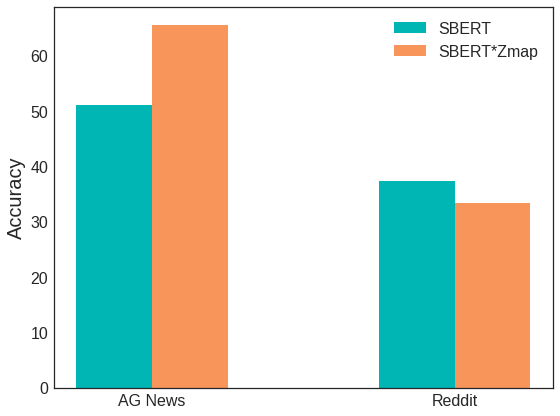

In [ ]:
plt.style.use("seaborn-white")
cldr_colors = ['#00b6b5', '#f7955b','#6c8cc7']

fig = plt.figure(figsize=(8,6))
width = 0.25
plt.bar(np.array([0, 1])-width/2, 
        [baseline_news_acc, baseline_reddit_acc], 
        width=width, 
        color=cldr_colors[0],  
        label='SBERT'
        )
plt.bar(np.array([0, 1])+width/2, 
        [zw2v_news_acc, zw2v_reddit_acc], 
        width=width, 
        color=cldr_colors[1], 
        label='SBERT*Zmap'
        )
plt.xticks([0,1], ['AG News', 'Reddit'], fontsize=16)#
plt.yticks(fontsize=16)
plt.ylabel("Accuracy", fontsize=20);
plt.legend(frameon=False, fontsize=16);
plt.tight_layout()
plt.savefig("accuracy_agnews_reddit.png", transparent=True, dpi=150)

# Error analysis

Let's take a closer look at how these datasets are composed to see if we can understand why some (AG News) perform well under a Zmap transformation and other (Reddit) perform worse! 

### Number of labels

The AG News dataset has only four categories, while our subset of Reddit contains posts from 10 different subreddits. 

In [ ]:
news_data.categories

['World', 'Sports', 'Business', 'Sci/Tech']

In [ ]:
reddit_data.categories

['fitness',
 'funny',
 'gaming',
 'personal finance',
 'politics',
 'relationships',
 'sex',
 'technology',
 'trees',
 'world news']

Additionally, the AG news examples are evenly distributed across the four categories. Not so for the Reddit dataset -- but we can change that.

In [ ]:
np.unique(news_data.labels, return_counts=True)

(array([0, 1, 2, 3]), array([1900, 1900, 1900, 1900]))

In [ ]:
np.unique(reddit_data.labels, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([2269, 4016, 4384, 1440, 3652, 6000, 2880, 1370, 4728, 2258]))

In [ ]:
df = pd.read_csv("data/reddit_subset_test.csv")

In [ ]:
subdf = df[df.category.isin(reddit_data.categories)]

In [ ]:
# sample exactly 1300 from each category
sample = subdf.groupby('category', group_keys=False).apply(
    lambda x: x.sample(min(len(x), 1300), random_state=42)
)

sample['category'] = pd.Categorical(sample.category)
sample['label'] = sample.category.cat.codes

In [ ]:
redditsample_data  = Dataset(
    examples = sample["summary"].tolist(),
    labels = sample.label.tolist(),
    categories = _prepare_category_names(sample))


Computing sentence representations: 100%|██████████| 814/814 [02:54<00:00,  4.65it/s]


In [ ]:
redditsample_acc, preds = predict_and_score(reddit_data, #redditsample_data, 
                                            reddit_categories, 
                                            Zmap=None, 
                                            return_predictions=True)
redditsample_acc

37.46923076923077

In [ ]:
redditsample_acc, preds_zw2v = predict_and_score(reddit_data, #redditsample_data, 
                                                  reddit_categories, 
                                                  Zmap=Zmap_w2v, 
                                                  return_predictions=True)
redditsample_acc

33.53076923076923

In [ ]:
redditsample_acc, preds_zred = predict_and_score(reddit_data, #redditsample_data, 
                                                  reddit_categories, 
                                                  Zmap=Zmap_redditwords, 
                                                  return_predictions=True)
redditsample_acc

25.6

In [ ]:
best = [p.best for p in preds]
best_zw2v = [p.best for p in preds_zw2v]
best_zred = [p.best for p in preds_zred]

In [ ]:
thing, best_counts = np.unique(best, return_counts=True)
_, best_zw2v_counts = np.unique(best_zw2v, return_counts=True)
_, best_zred_counts = np.unique(best_zred, return_counts=True)

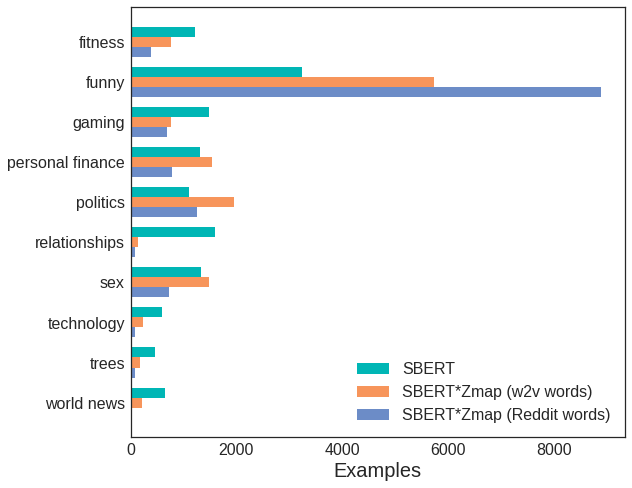

In [ ]:
plt.style.use("seaborn-white")

fig = plt.figure(figsize=(9,7))
ax = fig.add_subplot(111)

width = .25
ax.barh(np.array(thing)-width,
         best_counts,  
         height=width,
         color=cldr_colors[0],
         label='SBERT'
        )
ax.barh(np.array(thing),
         best_zw2v_counts, 
          
         height=width, 
         color=cldr_colors[1],
         label='SBERT*Zmap (w2v words)'
         )
ax.barh(np.array(thing)+width,
         best_zred_counts,
          
         height=width, 
         color=cldr_colors[2],
         label='SBERT*Zmap (Reddit words)'
         )
ax.set_yticks(thing)
ax.set_yticklabels(reddit_data.categories)
ax.invert_yaxis()
ax.tick_params(axis="both", labelsize=16)
ax.set_xlabel("Examples", fontsize=20);
ax.legend(frameon=False, fontsize=16);
plt.tight_layout()
plt.savefig("reddit_bycategory.png", transparent=True, dpi=150)

In [ ]:
news_acc, news_preds = predict_and_score(news_data, 
                                         news_categories, 
                                         Zmap=None, 
                                         return_predictions=True)

news_acc, news_preds_zw2v = predict_and_score(news_data, 
                                         news_categories, 
                                         Zmap=Zmap_w2v, 
                                         return_predictions=True)

news_best = [p.best for p in news_preds]
news_best_zw2v = [p.best for p in news_preds_zw2v]

other_thing, news_best_counts = np.unique(news_best, return_counts=True)
_, news_best_zw2v_counts = np.unique(news_best_zw2v, return_counts=True)

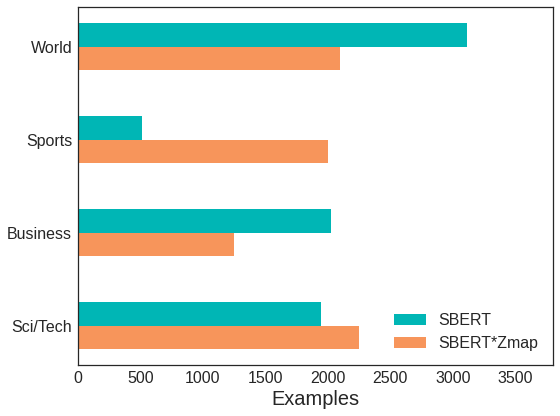

In [ ]:
plt.style.use("seaborn-white")

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)

width = .25
ax.barh(np.array(other_thing)-width/2, 
        news_best_counts, 
        height=width, 
        color=cldr_colors[0], 
        label='SBERT'
        )
ax.barh(np.array(other_thing)+width/2, 
        news_best_zw2v_counts, 
        height=width, 
        color=cldr_colors[1], 
        label='SBERT*Zmap'
        )

ax.set_yticks(other_thing)
ax.set_yticklabels(news_data.categories)
ax.invert_yaxis()
ax.tick_params(axis='both', labelsize=16)
ax.set_xlabel("Examples", fontsize=20)
ax.set_xlim(0, 3800)
ax.legend(frameon=False, fontsize=16);
plt.tight_layout()
plt.savefig("agnews_bycategory.png", transparent=True, dpi=150)

In [ ]:
sample['category'] = sample['category'].astype('str')
reddit_categories2 = [cat for cat in reddit_data.categories if cat != 'funny']
sample2 = sample.loc[sample.category.isin(reddit_categories2)]

sample2['category'] = pd.Categorical(sample2.category)
sample2['label'] = sample2.category.cat.codes

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
redditsample2_data  = Dataset(
    examples = sample2["summary"].tolist(),
    labels = sample2.label.tolist(),
    categories = _prepare_category_names(sample2))

Computing sentence representations: 100%|██████████| 732/732 [02:37<00:00,  4.66it/s]


In [ ]:
redditsample_acc, preds = predict_and_score(redditsample2_data, 
                                            len(reddit_categories2), 
                                            Zmap=None, 
                                            return_predictions=True)
redditsample_acc

42.87179487179487

In [ ]:
redditsample_acc, preds_zw2v = predict_and_score(redditsample2_data, 
                                                  len(reddit_categories2), 
                                                  Zmap=Zmap_w2v, 
                                                  return_predictions=True)
redditsample_acc

39.863247863247864

In [ ]:
redditsample_acc, preds_zred = predict_and_score(redditsample2_data, 
                                                  len(reddit_categories2), 
                                                  Zmap=Zmap_redditwords, 
                                                  return_predictions=True)
redditsample_acc

37.88034188034188

In [ ]:
fine_tune_alpha(alpha, redditsample2_data, sbert_vectors_redditwords, w2v_vectors_redditwords)

alpha: 0 	 score: 37.88034188034188
alpha: 0.1 	 score: 40.863247863247864
alpha: 1 	 score: 42.333333333333336
alpha: 5 	 score: 41.76068376068376
alpha: 10 	 score: 41.410256410256416
alpha: 15 	 score: 40.957264957264954


In [ ]:
fine_tune_alpha(alpha, redditsample2_data, sbert_vectors, w2v_vectors)

alpha: 0 	 score: 39.863247863247864
alpha: 0.1 	 score: 41.75213675213676
alpha: 1 	 score: 42.97435897435897
alpha: 5 	 score: 42.85470085470086
alpha: 10 	 score: 42.02564102564102
alpha: 15 	 score: 41.38461538461539
